In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re  

In [74]:
data = pd.read_csv('data/wine.csv')

In [75]:
# Проверка на наличие дублирующихся записей
duplicates = data.duplicated()

# Вывод количества дублирующихся записей
print(f"Количество дублирующихся записей: {duplicates.sum()}")

# Удаление дублирующихся записей
data = data.drop_duplicates()


Количество дублирующихся записей: 9983


In [122]:
# Проверка на наличие пропусков в данных
missing_values = data.isnull().sum()

print("Пропуски в столбцах:")
print(missing_values)

Пропуски в столбцах:
country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64


In [ ]:
display(data.head(5))

In [127]:

# Создайте копию датасета
fill_data = data.copy()

# Функция для извлечения года из title
def extract_year(title):
    match = re.search(r'\b(19|20)\d{2}\b', title)
    return match.group(0) if match else None

# Функция для извлечения region_1 из title (первые скобки справа)
def extract_region_1(title):
    match = re.search(r'\(([^()]*)\)[^()]*$', title)
    return match.group(1) if match else None

# Функция для извлечения designation из title
def extract_designation_from_title(title):
    # Удаляем все символы до и включая год
    designation = re.sub(r'^.*?\b(19|20)\d{2}\b\s+', '', title)
    # Удаляем все символы в скобках в конце строки
    designation = re.sub(r'\s+\(.*?\)$', '', designation).strip()
    return designation

# Извлечение года из title и создание новой колонки 'year'
fill_data['year'] = fill_data['title'].apply(extract_year)

# Заполнение пропущенных значений region_1 извлеченными значениями из title
fill_data['region_1'] = fill_data.apply(
    lambda row: extract_region_1(row['title']) if pd.isnull(row['region_1']) else row['region_1'], axis=1)

# Создание новой колонки 'designation_from_title' путем извлечения designation из title
#fill_data['designation_from_title'] = fill_data['title'].apply(extract_designation_from_title)

# Функция для заполнения пропущенных значений designation на основе моды region_2
def fill_missing_designation_region2(row, region2_mode):
    if pd.isnull(row['designation']):
        return region2_mode.get(row['region_2'], row['designation'])
    return row['designation']

# Вычисление моды для каждого region_2
region2_mode = fill_data.groupby('region_2')['designation'].agg(lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()

# Заполнение пропущенных значений designation модой соответствующего region_2
fill_data['designation'] = fill_data.apply(fill_missing_designation_region2, axis=1, region2_mode=region2_mode)

# Функция для заполнения пропущенных значений region_1 на основе моды province
def fill_missing_region_1_province(row, province_mode):
    if pd.isnull(row['region_1']):
        return province_mode.get(row['province'], row['region_1'])
    return row['region_1']

# Вычисление моды для каждого province
province_mode = fill_data.groupby('province')['region_1'].agg(lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()

# Заполнение пропущенных значений region_1 модой соответствующего province
fill_data['region_1'] = fill_data.apply(fill_missing_region_1_province, axis=1, province_mode=province_mode)

# Функция для заполнения пропущенных значений region_1 на основе моды designation
def fill_missing_region_1_designation(row, designation_mode):
    if pd.isnull(row['region_1']):
        return designation_mode.get(row['designation'], row['region_1'])
    return row['region_1']

# Вычисление моды для каждого designation
designation_mode = fill_data.groupby('designation')['region_1'].agg(lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()

# Заполнение пропущенных значений region_1 модой соответствующего designation
fill_data['region_1'] = fill_data.apply(fill_missing_region_1_designation, axis=1, designation_mode=designation_mode)

# Функция для заполнения пропущенных значений country на основе моды region_1
def fill_missing_country(row, region_mode):
    if pd.isnull(row['country']):
        return region_mode.get(row['region_1'], row['country'])
    return row['country']

# Вычисление моды для каждого region_1
region_mode = fill_data.groupby('region_1')['country'].agg(lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()

# Заполнение пропущенных значений country модой соответствующего region_1
fill_data['country'] = fill_data.apply(fill_missing_country, axis=1, region_mode=region_mode)

# Функция для заполнения пропущенных значений province на основе моды region_1
def fill_missing_province(row, region_province_mode):
    if pd.isnull(row['province']):
        return region_province_mode.get(row['region_1'], row['province'])
    return row['province']

# Вычисление моды для каждого region_1 для province
region_province_mode = fill_data.groupby('region_1')['province'].agg(lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()

# Заполнение пропущенных значений province модой соответствующего region_1
fill_data['province'] = fill_data.apply(fill_missing_province, axis=1, region_province_mode=region_province_mode)

# Функция для заполнения пропущенных значений designation на основе моды region_1
def fill_missing_designation_region1(row, region1_mode):
    if pd.isnull(row['designation']):
        return region1_mode.get(row['region_1'], row['designation'])
    return row['designation']

# Вычисление моды для каждого region_1
region1_mode = fill_data.groupby('region_1')['designation'].agg(lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()

# Заполнение пропущенных значений designation модой соответствующего region_1
fill_data['designation'] = fill_data.apply(fill_missing_designation_region1, axis=1, region1_mode=region1_mode)

# Заполнение пропущенных значений taster_name значением 'unknown'
#fill_data['taster_name'].fillna('unknown', inplace=True)
fill_data.fillna({'taster_name': 'unknown'}, inplace=True)

# Замена значений в taster_twitter_handle на 1, а пропусков на 0
fill_data['taster_twitter_handle'] = fill_data['taster_twitter_handle'].apply(lambda x: 0 if pd.isnull(x) else 1)

# Функция для заполнения пропущенных значений price на основе среднего значения title и округления до 1 знака после запятой
def fill_missing_price_title(row, title_mean):
    if pd.isnull(row['price']):
        return round(title_mean.get(row['title'], row['price']), 1)
    return row['price']

# Вычисление среднего значения price для каждого title и округления до 1 знака после запятой
title_mean = fill_data.groupby('title')['price'].mean().round(1).to_dict()

# Заполнение пропущенных значений price средним значением соответствующего title и округления до 1 знака после запятой
fill_data['price'] = fill_data.apply(fill_missing_price_title, axis=1, title_mean=title_mean)

# Функция для заполнения пропущенных значений price на основе среднего значения winery и округления до 1 знака после запятой
def fill_missing_price_winery(row, winery_mean):
    if pd.isnull(row['price']) or row['price'] == 0:
        return round(winery_mean.get(row['winery'], row['price']), 1)
    return row['price']

# Вычисление среднего значения price для каждого winery и округления до 1 знака после запятой
winery_mean = fill_data.groupby('winery')['price'].mean().round(1).to_dict()

# Заполнение пропущенных значений price средним значением соответствующего winery, если среднее значение title NULL или 0
fill_data['price'] = fill_data.apply(fill_missing_price_winery, axis=1, winery_mean=winery_mean)


# Функция для заполнения пропущенных значений designation из region_2 или region_1
def fill_missing_designation(row):
    if pd.isnull(row['designation']):
        if pd.notnull(row['region_2']):
            return row['region_2']
        elif pd.notnull(row['region_1']):
            return row['region_1']
    return row['designation']

# Заполнение пропущенных значений designation из region_2 или region_1
fill_data['designation'] = fill_data.apply(fill_missing_designation, axis=1)


# Функция для заполнения пропущенных значений price на основе среднего значения designation и округления до 1 знака после запятой
def fill_missing_price_designation(row, designation_mean):
    if pd.isnull(row['price']) or row['price'] == 0:
        return round(designation_mean.get(row['designation'], row['price']), 1)
    return row['price']

# Вычисление среднего значения price для каждого designation и округления до 1 знака после запятой
designation_mean = fill_data.groupby('designation')['price'].mean().round(1).to_dict()

# Заполнение пропущенных значений price средним значением соответствующего designation, если среднее значение title NULL или 0
fill_data['price'] = fill_data.apply(fill_missing_price_designation, axis=1, designation_mean=designation_mean)


# Функция для заполнения пропущенных значений price на основе среднего значения points и округления до 1 знака после запятой
def fill_missing_price_points(row, points_mean):
    if pd.isnull(row['price']) or row['price'] == 0:
        return round(points_mean.get(row['points'], row['price']), 1)
    return row['price']

# Вычисление среднего значения price для каждого points и округления до 1 знака после запятой
points_mean = fill_data.groupby('points')['price'].mean().round(1).to_dict()

# Заполнение пропущенных значений price средним значением соответствующего points, если среднее значение title NULL или 0
fill_data['price'] = fill_data.apply(fill_missing_price_points, axis=1, points_mean=points_mean)


# Заполнение пропущенных значений year значением -1
fill_data.fillna({'year': -1}, inplace=True)

# Заполнение пропущенных значений region_2 значением unknown
fill_data.fillna({'region_2': 'unknown'}, inplace=True)


# Заполнение пропущенных значений variety значением unknown
fill_data.fillna({'variety': 'unknown'}, inplace=True)

display(fill_data.isnull().sum())

#отбрасываем строки с числом пропусков более 2 в строке
m = fill_data.shape[1] #число признаков после удаления столбцов
drop_data = fill_data.dropna(thresh=m-2, axis=0)

# Отображение первых нескольких строк обновленного датасета
display(drop_data.head(3))

#выводим результирующую долю пропусков
display(drop_data.isnull().mean())



country                  41
description               0
designation              11
points                    0
price                     0
province                 41
region_1                 41
region_2                  0
taster_name               0
taster_twitter_handle     0
title                     0
variety                   0
winery                    0
year                      0
dtype: int64

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,17.0,Sicily & Sardinia,Etna,unknown,Kerin O’Keefe,1,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Douro,unknown,Roger Voss,1,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011
2,US,"Tart and snappy, the flavors of lime flesh and...",Estate,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,1,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013


country                  0.0
description              0.0
designation              0.0
points                   0.0
price                    0.0
province                 0.0
region_1                 0.0
region_2                 0.0
taster_name              0.0
taster_twitter_handle    0.0
title                    0.0
variety                  0.0
winery                   0.0
year                     0.0
dtype: float64

<Axes: >

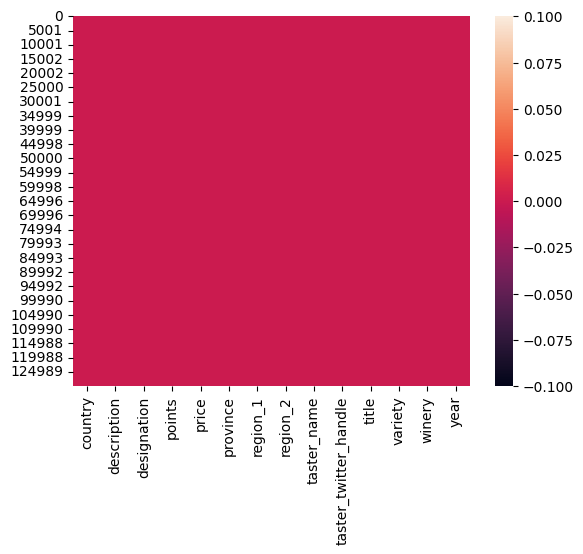

In [129]:
sns.heatmap(drop_data.isnull()) # убеждаемся, что датасет без пропусков

In [130]:
df = drop_data.to_csv('data/wine_cleared.csv', index=False) # сохраняем очищенный датасет для дальнейшей работы